# How to Build an ARIMA Model in Python

[DataCamp Tutorial](https://www.datacamp.com/tutorial/arima)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gvyshnya/gold-future-prices")

print("Path to dataset files:", path)

Path to dataset files: /Users/malena/.cache/kagglehub/datasets/gvyshnya/gold-future-prices/versions/2


In [18]:
path_to_csv = path + "/future-gc00-daily-prices.csv"

# Read the CSV, parse 'Date' column as datetime, and set it as the index
data = pd.read_csv(    path_to_csv,    parse_dates=["Date"],    dayfirst=False,    index_col="Date")

# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

In [19]:
# Clean the "Close" column

data["Close"] = data["Close"].replace(',', '', regex=True)
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=["Close"], inplace=True)
data.head()

,Open,High,Low,Close
Date,,,,
2009-04-24,905.50,915.40,904.20,914.1
2009-04-27,915.00,919.70,905.80,908.2
2009-04-28,907.20,907.70,884.60,893.6
2009-04-29,894.00,904.00,888.30,900.5
2009-04-30,898.60,900.80,880.10,891.2


I had mentioned that weekend days might be recognized as NA. That's can be the case, and would require an extra step. Luckily, statsmodels treats the data as a sequential index without strictly enforcing regular time intervals, allowing our model to compile even weekend gaps. 

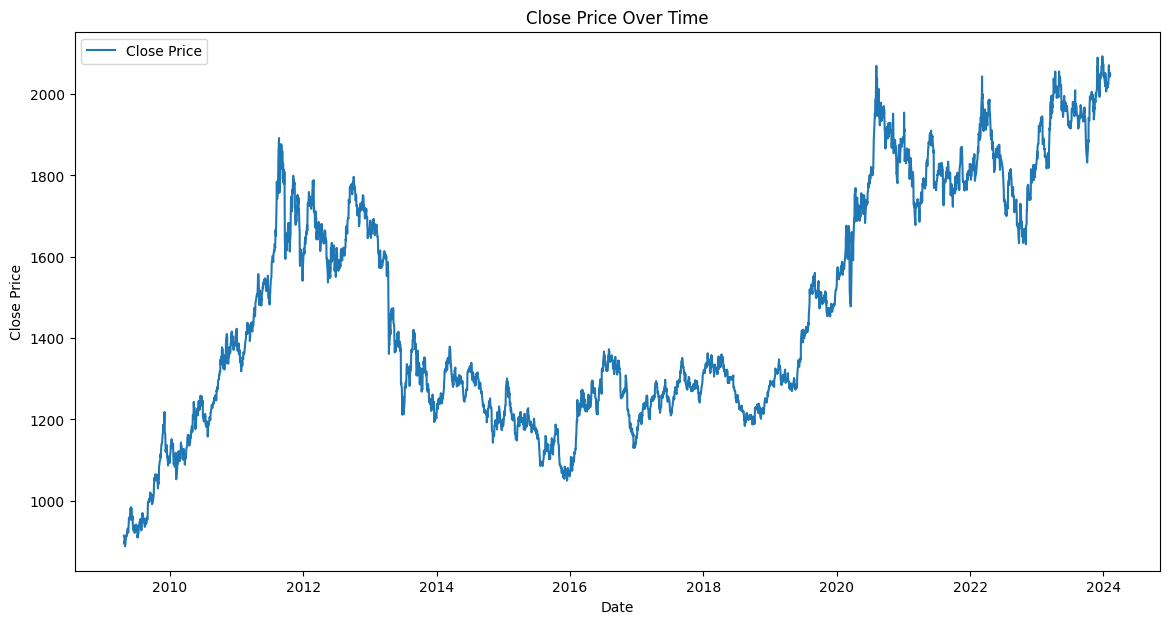

In [20]:
# Plotting the original Close price

plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Close"], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


While ARIMA models can deal with non-stationarity up to a point, they cannot effectively account for time-varying variance. In other words, for an ARIMA model to really work, the data has to be stationary.

Looking at the plot, above, we can see that the data is, in fact, not stationary because there is a clear trend. Also, it looks like there is non-constant variance at different time points. We can use the Augmented Dickey-Fuller test to test our intuition and see if our data has a constant mean and variance, and put numbers to it. 

### Aside: ADF Test
[youtube tutorial](https://www.youtube.com/watch?v=2cWsi6dfJ90&t=22s)

- Formal test to see if a time series is stationary
> H0 = Non Stationary (has a unit root)
> Ha = Sationary (does not have a unit root)
- Stationary --> mean and std dev are not changing over time; no long term trend or seasonality
- Unit Root is a characteristic of a time series that makes it non-stationary
- ADF is considered a *Unit Root Test*

Test Info:
- Significance level set to 0.05
- Small p-value (<0.05) suggests rejecting null-hypothesis --> the series is stationary and does not include a unit root
> remember: the p-value is the 'observed significance level'; it is the probability of getting a value of z (z = (observed - expected) / SE) as extreme or more extreme than the observed z, assuming H0 is true.
- e.g., p-value = 0.02 = Stationary
- e.g., p-value = 0.12 = Not Srationary

In [43]:
np.random.seed(17)

In [44]:
stationary_data = np.random.normal(size=100)
non_stationary_data = np.cumsum(np.random.normal(size=100))

Text(0.5, 1.0, 'Non-Stationary Data')

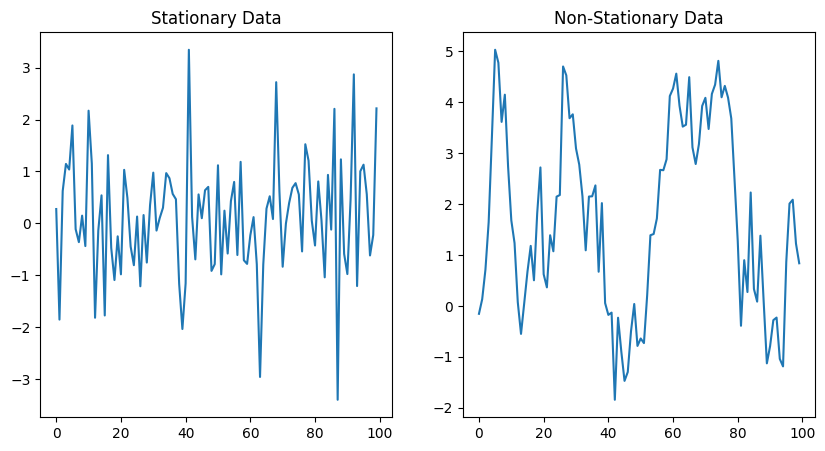

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(stationary_data)
plt.title('Stationary Data')

plt.subplot(1,2,2)
plt.plot(non_stationary_data)
plt.title('Non-Stationary Data')

In [46]:
result = adfuller(stationary_data)

In [47]:
print(result)

(np.float64(-10.725184743113727), np.float64(3.0783824340857604e-19), 0, 99, {'1%': np.float64(-3.498198082189098), '5%': np.float64(-2.891208211860468), '10%': np.float64(-2.5825959973472097)}, np.float64(267.2996649869879))


In [48]:
print('ADF Test Statistic:', result[0])
print('p-value:', result[1])
print('Number of lags:', result[2])
print('Observations used in test:', result[3])
print('Critical Values:', result[4])
print('Information Criterion (IC):',result[5])

ADF Test Statistic: -10.725184743113727
p-value: 3.0783824340857604e-19
Number of lags: 0
Observations used in test: 99
Critical Values: {'1%': np.float64(-3.498198082189098), '5%': np.float64(-2.891208211860468), '10%': np.float64(-2.5825959973472097)}
Information Criterion (IC): 267.2996649869879


In [49]:
adf_stat, p_value, lads, n_obs, crit_values, ic_best = result

In [50]:
p_value

np.float64(3.0783824340857604e-19)

In [57]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("Reject H0, Data is Stationary")
    else:
        print("Fail to reject H0, Data IS NOT Stationary")

In [58]:
adf_test(stationary_data)

ADF Statistic: -10.7252
p-value: 0.0000
Reject H0, Data is Stationary


In [56]:
adf_test(non_stationary_data)

ADF Statistic (Original): -2.7476
p-value (Original): 0.0662
Fail to reject H0, Data IS NOT Stationary


### Back to ARIMA

In [59]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(data["Close"])
print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
data['Close_Diff'] = data['Close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(data["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")

if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -1.4367
p-value (Original): 0.5646
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -19.1308
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


> **Differencing:** Making data stationary by subtracting each observation from the previous one, until the data is stationary. (Here we only do first oder i.e., differecing is performed once)

"A quick note on differencing. To perform differencing, we subtract each observation from the previous one to give us a new time series of first differences. (The new time series is now one element shorter than the original.) If the differenced series is still not stationary, we can take a second difference by differencing the original series again, and we can continue differencing the series until it finally becomes stationary. The order of differencing required is the minimum number of differences needed to get a series with no autocorrelation."

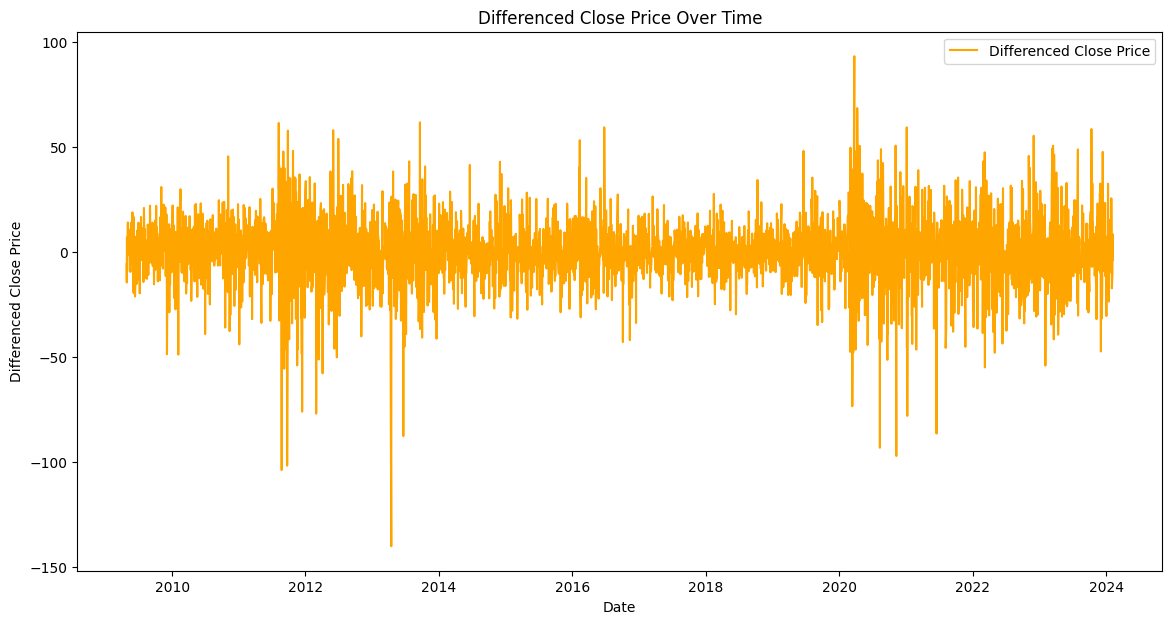

In [60]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_Diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

### Model Identification

We have to consider p, d, and q terms that go into our ARIMA model when we build it.
- **p:** number of lagged observations. Determines how far back we go in time to predict the current observation. Done by looking at the autocorrelations of our time series.
- **d:** order of differencing. Just mentioned. Differencing between consecutive timesteps. d = order of differencing at which the dara becomes stationary
- **q:** order of the moving average part of the model. MA in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations. q represents the number of lagged forecast errors included in the model.

> "To be clear, the p, d, and q values in ARIMA represent the model's order (lags for autoregression, differencing, and moving average terms), but they are not the actual parameters being estimated. Once the p, d, and q values are chosen, the model estimates additional parameters, such as coefficients for the autoregressive and moving average terms, through maximum likelihood estimation (MLE)."

We use tools like ACF or PACF to determine p, d, and q:
- p = no. of lags where PACF cuts it off
- q = no. of lags where ACF cuts it off
- d = create a situation where, after differencing, the data resembles white noise

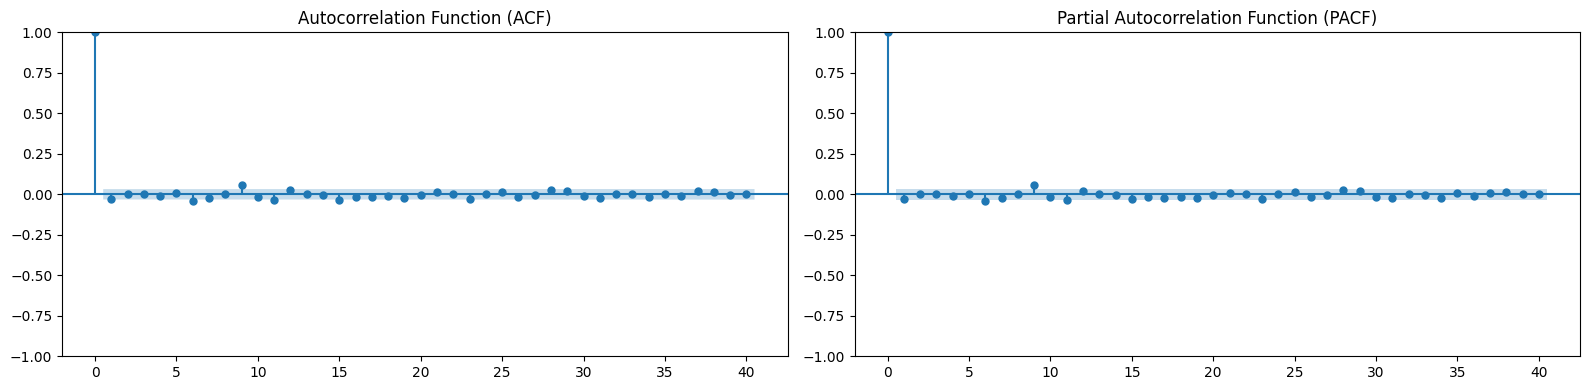

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Choose p, q = 1 because we see a significant spike in the first lag for both.

### Forecasting

In [65]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["Close"], order=(1,1,1))
model_fit = model.fit()

/Users/malena/Desktop/Projects/Python/.practice-venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malena/Desktop/Projects/Python/.practice-venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malena/Desktop/Projects/Python/.practice-venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/malena/Desktop/Projects/Python/.practice-venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/malena/Desktop/Projects/Python/.practice-venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


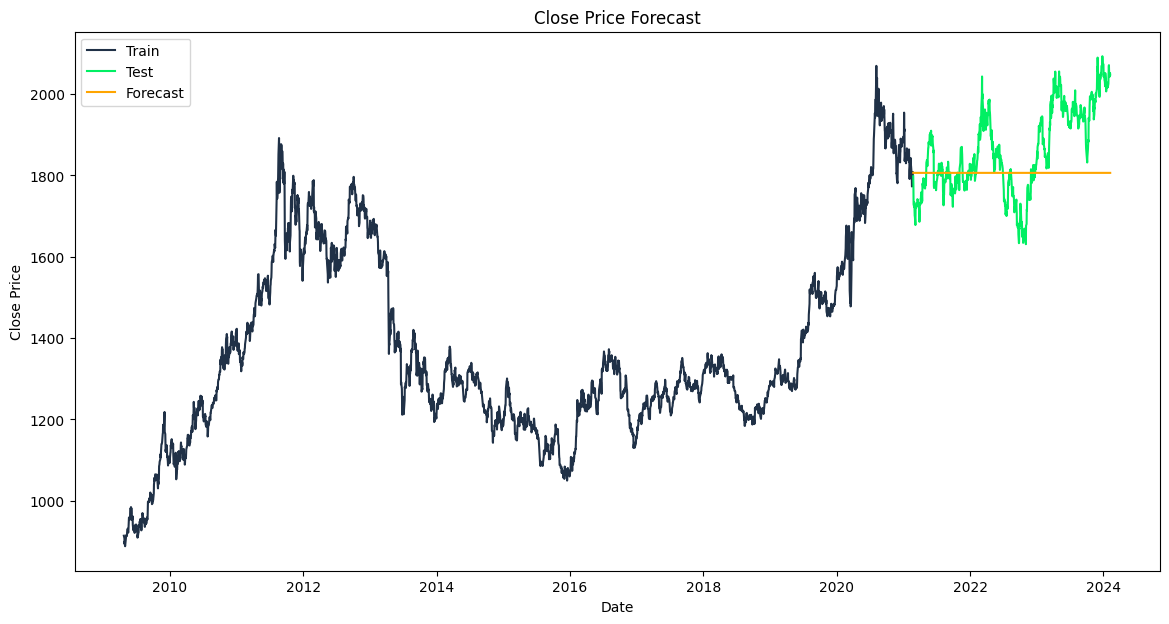

In [66]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Evaluate

Check AIC and BIC ([more details](https://medium.com/@jshaik2452/choosing-the-best-model-a-friendly-guide-to-aic-and-bic-af220b33255f))

In [69]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

#these numbers help evaluate the model in comparison to other models

AIC: 24602.97426066798
BIC: 24620.97128230771


In [70]:
#Also evaluate using RMSE
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 118.5339


### ARIMA Common Uses

- **Economics and Finance**: ARIMA has a high capacity for handling financial time series that often contain complex autocorellations and interactions between multiple economic indicators. Ability to model lag effects and incorporate differencing makes it good at forecasting volatile metrics like stock prices or exchange rates.

- **Weather**: Can be used for short and long-term temperature and precipitation forecasting,, incorporating air-sea interactions and many other factors. Can also use historical weather data to better understand trends in climate and predict what future climates will look like.

- **Supply chain management**: Can help manage inventory or anticipate disruptions based on historical patterns and lead times (demand forecasting, supply chain optimisation)

- **Healthcare**: Disease outbreak prediction, hospital admission forecasting, patient monitoring (warn early signs of health issues)


## Factors for Improving ARIMA Forecasting

**Overfitting and underfitting**: Can come down to choosing the right *p, d,* and *q* values. If we make the model too complex, it will focus not only on the data but the noise too, and be unable to generalise to new data. If we make our model too simple (underfit), our model won't be able to capture all underlying patterns. 

- Prevent overfitting by using fewer lag terms and possibly fewer differencing terms.
- Prevent underfitting by increasing number of autoregressive terms (if appropriate)
- Validation/cross-validation can help find the right values.


**Stationarity**: The statistical assumption that data is stationary. Unreliable forecasts and spurious relationships can result in non-stationary data. 

- Differencing, log transformations, or seasonal adjustments can be used to make non-stationary data stationary.


**Seasonality**: Real-world data can have fixed intervals over which they exhibit repeated patters. Disregarding these can result in incorrect/inaccurate forecasting. 

- Need seasonal differences and seasonal AR and MA terms in addition to p and q values,


**Residual analysis**: Check if the residual series that is generated is stationary! This way we check if our model has been able to find and work with the dynamics in the data, and that the model has not missed any information or complexity.

- "Statistical tests and visual diagnostics, including the Ljung-Box test, as well as histograms and other diagnostic plots can be used to verify that the model is adequate."